# Importance sampling revisited

In the previous session, you saw the posterior distribution below for estimating the unknown mean and standard deviation in a Gaussian mixture model. [See the previous pre-class work](https://gist.github.com/cscheffler/b0a31f9a2749804ac1268d9ab20ffa7f) for the model details, if you need to refresh your memory.

$$p(\mu, \sigma\,|\,\{x\}) \propto \underbrace{\Bigg.\text{Normal}(\mu\,|\,0, 5^2)\,\text{Gamma}(\sigma\,|\,2, 1)}_{\text{prior}}\, \underbrace{\prod_{i=1}^{20} \big[0.7\text{Normal}(x_i\,|\,0,4^2) + 0.3\text{Normal}(x_i\,|\,\mu,\sigma^2)\big]}_{\text{likelihood}}$$

In [7]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [8]:
# The data set from the model specification
data = [
  -4.127935, -2.152332, 3.046302, -10.77442, -6.985155, 5.536106, 1.294746,
  7.638998, -5.650118, -4.478067, -0.4551435, -3.969413, -0.4225518, -2.462094,
  1.886675, 3.095567, 4.310003, 3.305034, 0.8548273, 4.368213]

# The unnormalized posterior distribution function, as defined above.
def unnormalized_posterior(mu, sigma, data):
    if sigma < 0:
        # The probably of sigma < 0 is 0. It will become clear why we need this
        # a little further down – samples from our proposal distribution might
        # have sigma < 0.
        return 0
    else:
        return (
            sts.norm.pdf(mu, loc=0, scale=5) *
            sts.gamma.pdf(sigma, a=2, scale=1) *
            np.prod(
                0.7 * sts.norm.pdf(data, loc=0, scale=4) +
                0.3 * sts.norm.pdf(data, loc=mu, scale=sigma)))

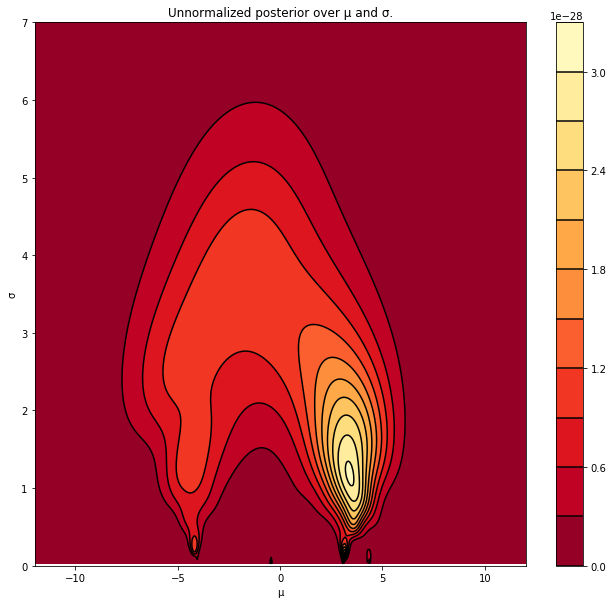

In [9]:
# Plot of the unormalized posterior using a 2-d contour plot.
plot_mu_range = [-12, 12]
plot_sigma_range = [0, 7]

mu = np.linspace(plot_mu_range[0], plot_mu_range[1], 300)
sigma = np.linspace(plot_sigma_range[0], plot_sigma_range[1], 300)
posterior = np.empty((len(sigma), len(mu)))
for i in range(len(sigma)):
    for j in range(len(mu)):
        posterior[i,j] = unnormalized_posterior(mu[j], sigma[i], data)

plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

In class, we computed some expected values using importance sampling and saw that choosing a good proposal distribution is not necessarily straightforward. How can we monitor convergence of the importance sampling method, and how do we even know if we are converging to the right solution?

In this notebook we look at 2 proposal distributions for the task of computing the expected value $E[\sigma^2]$ under the posterior distribution. The first proposal distribution is provided for you below as a demonstration. Your task (see further down) is to do importance sampling with a second proposal distribution, and to compare the two proposals.

## Proposal distribution 1: Bimodal

This proposal distribution is designed to put most of its probability mass on the two major peaks seen in the posterior.

We generate samples from the distribution and display them on the contour plot.

In [10]:
# Proposal distribution: Bimodal. A mixture of two normal distributions over mu
# with means at -4 and 4. A single normal distribution over sigma.

# Probability density function of the bimodal proposal distribution
def bimodal_pdf(mu, sigma):
    return (
        (
            0.5 * sts.norm.pdf(mu, loc=4, scale=1.5) +
            0.5 * sts.norm.pdf(mu, loc=-4, scale=1.5)) *
        sts.norm.pdf(sigma, loc=1.5, scale=0.75))

# Generate samples from the bimodal proposal distribution
def bimodal_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.5, size=size)    
    mu_samples = (
        selector * sts.norm.rvs(loc=4, scale=1.5, size=size) +
        (1-selector) * sts.norm.rvs(loc=-4, scale=1.5, size=size))

    # Repeatedly sample sigmas until they are all greater than 0.
    sigma_samples = np.zeros(size)
    while True:
        not_positive = sigma_samples <= 0
        how_many = sum(not_positive)
        if how_many == 0:
            break
        sigma_samples[not_positive] = sts.norm.rvs(loc=1.5, scale=0.75, size=how_many)

    return {
        'mu': mu_samples,
        'sigma': sigma_samples}

In [11]:
# Generate samples
num_samples = 100000
proposal_distribution = bimodal_pdf
proposal_samples = bimodal_rvs(num_samples)

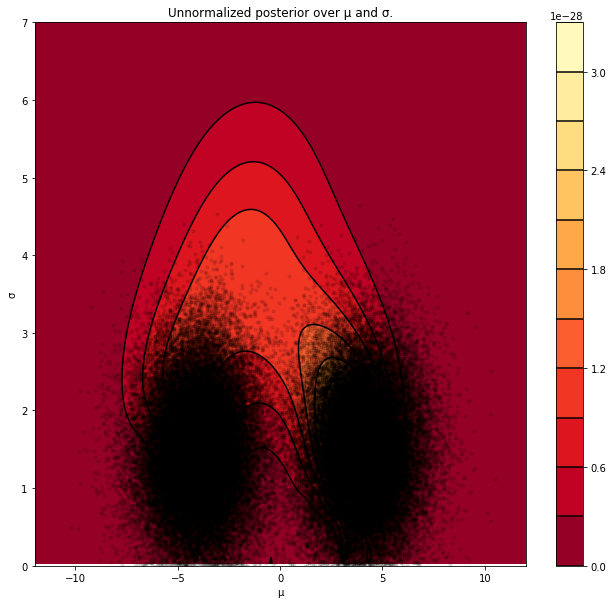

In [12]:
# Plot of the samples on the level plot
plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(proposal_samples['mu'], proposal_samples['sigma'], 'k.', alpha=0.1)
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

Next, to do importance sampling, we calculate the weights associated with each of these samples as the ratio between the true (unnormalized) pdf and the proposal pdf — $w_i = p(\mu_i, \sigma_i) / q(\mu_i, \sigma_i).$

In [13]:
# Calculate the importance weights, p(sample) / q(sample)
weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(proposal_samples['mu'][i], proposal_samples['sigma'][i], data)
    q_value = proposal_distribution(proposal_samples['mu'][i], proposal_samples['sigma'][i])
    weights[i] = p_value / q_value

Since we want to approximate $E[\sigma^2]$ we use the weights and the $\sigma$ part of our samples from the proposal distribution to calculate the approximation.

$$E[\sigma^2] \approx \dfrac{\sum_i w_i f(\sigma_i)}{\sum_i w_i} \text{ with } f(\sigma) = \sigma^2$$

We also use the partial sums to plot the convergence of the estimator above as the number of samples, $n$, goes from 1 to 100,000.

Estimate for σ² with 100000 samples: 7.058507717207928


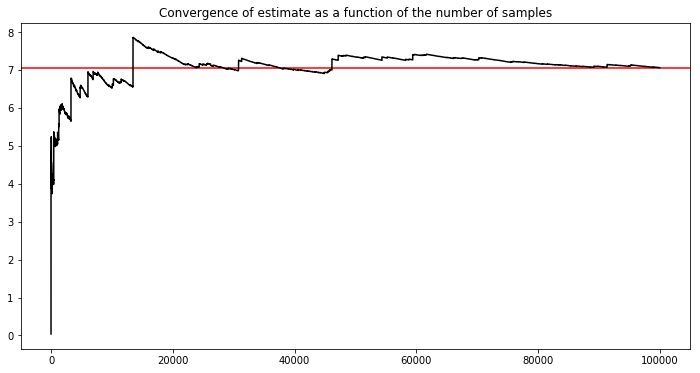

In [14]:
f_values = proposal_samples['sigma'] ** 2
estimate = np.sum(f_values * weights) / np.sum(weights)
print('Estimate for σ² with', num_samples, 'samples:', estimate)

convergence = np.cumsum(f_values * weights) / np.cumsum(weights)
plt.figure(figsize=(12, 6))
plt.axhline(estimate, color='red')
plt.plot(convergence, 'k-')
plt.title('Convergence of estimate as a function of the number of samples')
plt.show()

## Proposal distribution 2: Broad Gaussian distribution

Below is the definition of a very different proposal distribution. This one does not try and place most of its probability mass near the peaks of the posterior distribution. Rather, it is a broad Gaussian distribution that tries to cover most of the area (most of the $\mu$ and $\sigma$ values) where the posterior seems to have any amount of mass.

### Task

Repeat the steps that were followed above, for the first proposal distribution.

 1. Use this proposal distribution to generate samples.
 2. Plot the samples on the contour plot to see which parts of the posterior distribution are targeted by the proposal distribution.
 3. Calculate the importance weights and estimate $E[\sigma^2]$.
 4. Comment on the results and compare the results from the two proposal distributions.
 5. Which proposal distribution converges more quickly for this estimate?
 6. Which proposal distribution do you think is more accurate and why?
 7. Comment on how we should go about selecting a good proposal distribution.

Paste your plots, results, and answers to each of the questions above in a Google doc, make sure it is shared and be ready to paste a link to your doc into a poll.

We build on this activity in class.

In [15]:
# Proposal distribution: Broad Gaussian. A single normal distribution
# over mu and a single normal distribution over sigma.

# Probability density function of the broad Gaussian proposal distribution.
def broad_pdf(mu, sigma):
    # Probability density function of the broad Gaussian proposal distribution.
    return (
        sts.norm.pdf(mu, loc=0, scale=4) *
        sts.norm.pdf(sigma, loc=4, scale=2.5))

# Generate samples from the broad Gaussian proposal distribution.
def broad_rvs(size):
    mu_samples = sts.norm.rvs(loc=0, scale=4, size=size)
    sigma_samples = sts.norm.rvs(loc=4, scale=2.5, size=size)
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}

In [16]:
# Generate samples
num_samples = 100000
proposal_distribution = broad_pdf
proposal_samples = broad_rvs(num_samples)

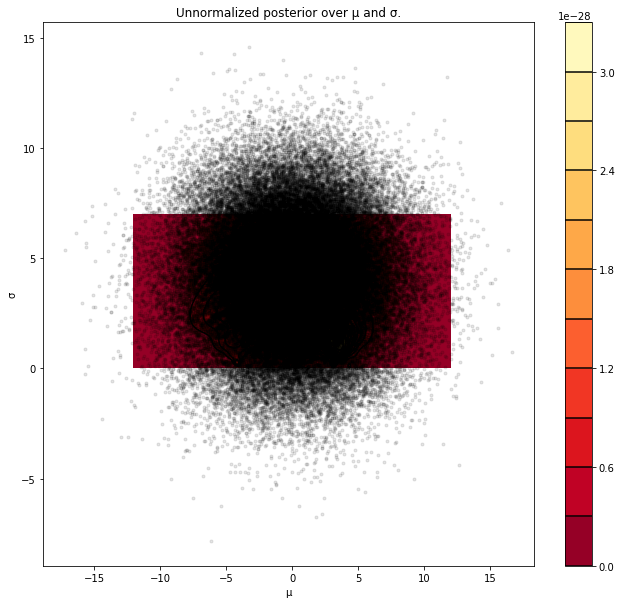

In [17]:
# Plot of the samples on the level plot
plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(proposal_samples['mu'], proposal_samples['sigma'], 'k.', alpha=0.1)
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

In [18]:
# Calculate the importance weights, p(sample) / q(sample)
weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(proposal_samples['mu'][i], proposal_samples['sigma'][i], data)
    q_value = proposal_distribution(proposal_samples['mu'][i], proposal_samples['sigma'][i])
    weights[i] = p_value / q_value

Estimate for σ² with 100000 samples: 10.720903796141831


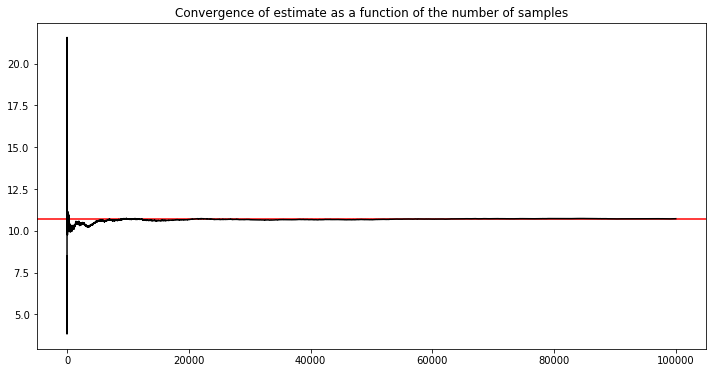

In [19]:
f_values = proposal_samples['sigma'] ** 2
estimate = np.sum(f_values * weights) / np.sum(weights)
print('Estimate for σ² with', num_samples, 'samples:', estimate)

convergence = np.cumsum(f_values * weights) / np.cumsum(weights)
plt.figure(figsize=(12, 6))
plt.axhline(estimate, color='red')
plt.plot(convergence, 'k-')
plt.title('Convergence of estimate as a function of the number of samples')
plt.show()